# BBC News Classification Project

The goal of this notebook is to classify BBC news articles into one of five categories: business, entertainment, politics, sport, and tech. The dataset is from [Kaggle](https://www.kaggle.com/c/learn-ai-bbc/data).

We are going to use a supervised learning model and compare it to an unsupervised learning model(Matrix Factorization).
This notebook is the final deliverable for the course [Unsupervised Algorithms in Machine Learning](https://www.coursera.org/learn/unsupervised-algorithms-in-machine-learning)

## Setup

In [199]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.model_selection import train_test_split            
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import NMF
from itertools import permutations
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cozie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cozie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cozie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [200]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [201]:
sns.set_style('dark')
sns.set_palette('muted', color_codes=True)  
random_seed = 0
np.random.seed(random_seed)

In [202]:
os.environ['KAGGLE_CONFIG_DIR'] = '.kaggle\kaggle.json'
!kaggle competitions download -c learn-ai-bbc -p data 
with zipfile.ZipFile('data\learn-ai-bbc.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

learn-ai-bbc.zip: Skipping, found more recently modified local copy (use --force to force download)


## EDA

The data consist of 1490 rows, each row representing a news article. There are 3 columns: ArticleId, Text and Category.

In [203]:
df_train_news = pd.read_csv('data\BBC News Train.csv')
df_train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [204]:
df_train_news.sample(10)

,ArticleId,Text,Category
9,1866,fockers fuel festive film chart comedy meet th...,entertainment
354,1349,tory candidate quits over remark a conservativ...,politics
1227,1572,bath faced with tindall ultimatum mike tindall...,sport
907,1155,chancellor rallies labour voters gordon brown ...,politics
575,307,young debut cut short by ginepri fifteen-year-...,sport
302,435,s korean lender faces liquidation creditors of...,business
703,756,us to rule on yukos refuge call yukos has said...,business
298,25,mobile audio enters new dimension as mobile ph...,tech
1136,1611,actress roberts takes spider role actress juli...,entertainment
1447,1730,us prepares for hybrid onslaught sales of hybr...,business


We are going to change the index to ArticleId and then look for duplicated articles.

In [205]:
df_train_news.set_index('ArticleId', inplace=True)
df_train_news['Category'] = df_train_news['Category'].str.capitalize()

In [206]:
df_train_news[df_train_news.duplicated('Text')].groupby('Category').agg({'Text': 'count'})  

,Text
Category,
Business,1
Entertainment,10
Politics,8
Sport,4
Tech,27


There are 51 duplicated articles. We are going to drop them. 

In [207]:
df_train_news.drop_duplicates('Text', inplace=True) 

Let's analyze the distribution of the categories.

(0.0, 400.0)

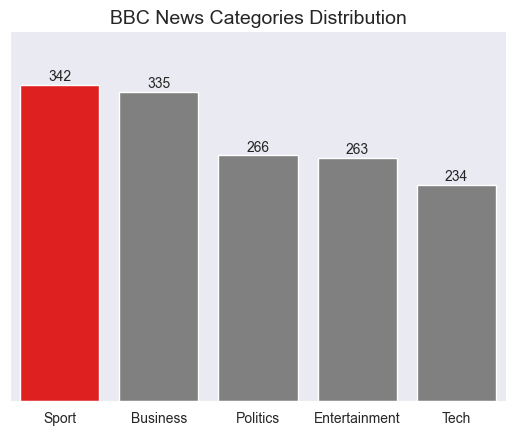

In [208]:
data = df_train_news['Category'].value_counts()
colors = ['grey' if (x < max(data)) else 'red' for x in data.values]
fig = sns.barplot(x=data.index, y=data.values, palette=colors)

sns.despine()
plt.title('BBC News Categories Distribution', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=True)       
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+5,s='{:.0f}'.format(height), ha='center')
plt.ylim(0,400)

As we can see, the categories are somewhat evenly distributed.

Let's take a look at a random article.

In [209]:
df_train_news.sample(1, random_state=42)

,Text,Category
ArticleId,,
1066,bellamy under new fire newcastle boss graeme s...,Sport


In [210]:
exmpl_index = 1066
df_train_news.loc[exmpl_index, 'Text']

'bellamy under new fire newcastle boss graeme souness has reopened his dispute with craig bellamy after claiming the welshman was  not good enough  for the magpies. bellamy left newcastle to join celtic on loan after a major row with souness. souness - who refused to refer to the 25-year-old by name - said bellamy did not score enough goals  the chap that s just gone has scored 9.3 goals a season in his time in senior football - half of those weren t even in the top flight   said souness.  that s not good enough for a striker at a club like this.  we need to have two strikers who are near 20 goals on a regular basis.   bellamy turned down a move to birmingham in favour of joining celtic after a disagreement about the welsh international playing out of position quickly escalated. earlier in the week  souness had said that he risked losing the confidence of the players and damaging his own reputation if he had not taken a hard line after bellamy accused him of lying.   there are certain 

There is some cleaning to do, for example removing punctuation, numbers, etc.

Now, since the input data is text, we first need to clean it up for NLP, we are going to follow some steps recommended by [this article](https://www.analyticsvidhya.com/blog/2021/05/natural-language-processing-step-by-step-guide/).

In [211]:
df_train_news['num_words_no_pre'] = df_train_news['Text'].apply(lambda x: len(x.split()))

df_train_news['Text'] = df_train_news['Text'].apply(lambda x: re.sub("[^a-zA-Z]", ' ',x))
df_train_news['num_words_simple_pre'] = df_train_news['Text'].apply(lambda x: len(x.split()))
print(df_train_news['Text'][exmpl_index])

bellamy under new fire newcastle boss graeme souness has reopened his dispute with craig bellamy after claiming the welshman was  not good enough  for the magpies  bellamy left newcastle to join celtic on loan after a major row with souness  souness   who refused to refer to the    year old by name   said bellamy did not score enough goals  the chap that s just gone has scored     goals a season in his time in senior football   half of those weren t even in the top flight   said souness   that s not good enough for a striker at a club like this   we need to have two strikers who are near    goals on a regular basis    bellamy turned down a move to birmingham in favour of joining celtic after a disagreement about the welsh international playing out of position quickly escalated  earlier in the week  souness had said that he risked losing the confidence of the players and damaging his own reputation if he had not taken a hard line after bellamy accused him of lying    there are certain t

First we are going to tokenize the text, which means splitting it into words.

In [212]:
tokens_exmpl = nltk.word_tokenize(df_train_news['Text'][exmpl_index])  
tokens_exmpl[:10]

['bellamy',
 'under',
 'new',
 'fire',
 'newcastle',
 'boss',
 'graeme',
 'souness',
 'has',
 'reopened']


Then we are going to remove stop words, which are words that don't add much meaning to the text, such as "the", "a", "an", etc. 

In [213]:
stopwords = nltk.corpus.stopwords.words('english')
filtered_tokens = [token for token in tokens_exmpl if token not in stopwords]
filtered_tokens[:10]

['bellamy',
 'new',
 'fire',
 'newcastle',
 'boss',
 'graeme',
 'souness',
 'reopened',
 'dispute',
 'craig']

As we can see, the stop words have been removed. Now we are going to lemmatize the words, which means reducing them to their root form. For example, "running" and "ran" would both be reduced to "run". This technique is chosen over stemming because from what I've read, stemming can sometimes reduce words to non-existent words and that would be bad for our model.

In [214]:
lemmatizer = nltk.stem.WordNetLemmatizer()
lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
lemmatized_tokens[:10]

['bellamy',
 'new',
 'fire',
 'newcastle',
 'bos',
 'graeme',
 'souness',
 'reopened',
 'dispute',
 'craig']

This process is going to be applied to all the articles in the dataset.

In [215]:
def preprocess_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token for token in tokens if token not in stopwords]
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in stopwords_removed]
    return ' '.join(lemmatized)
df_train_news['Text_preprocessed'] = df_train_news['Text'].apply(preprocess_article)

Let's take a look at average word count by article using the different phases of the cleaning process.

(0.0, 450.0)

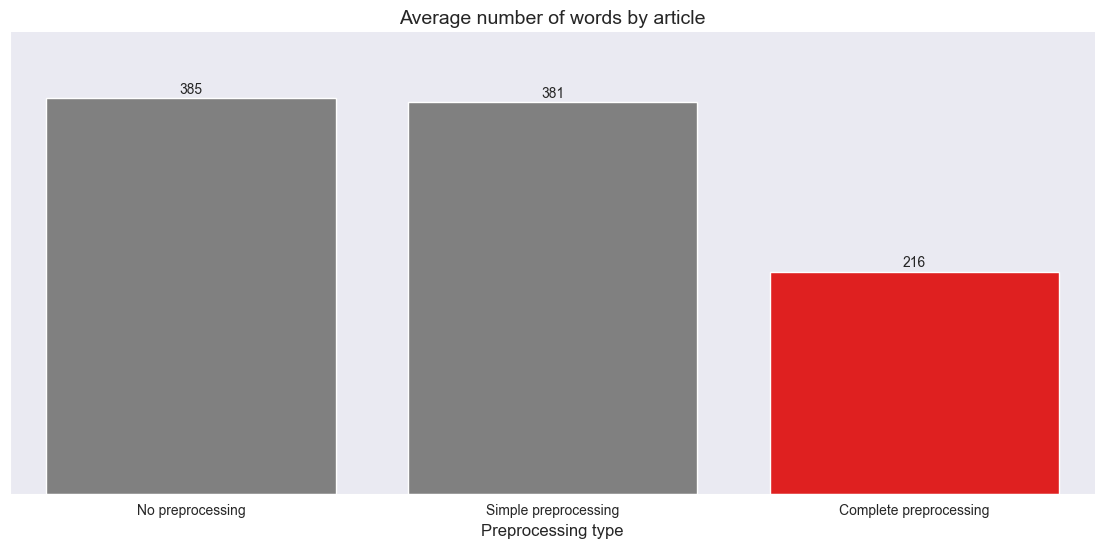

In [216]:
df_train_news['num_words_pre'] = df_train_news['Text_preprocessed'].apply(lambda x: len(x.split()))
avg_words_no_pre = df_train_news['num_words_no_pre'].mean()
avg_words_simple_pre = df_train_news['num_words_simple_pre'].mean()
avg_words_pre = df_train_news['num_words_pre'].mean()

data = pd.Series([avg_words_no_pre, avg_words_simple_pre, avg_words_pre], index=['No preprocessing', 'Simple preprocessing', 'Complete preprocessing'])
colors = ['grey' if (x > min(data)) else 'red' for x in data.values]
plt.figure(figsize=(14,6))
fig = sns.barplot(x=data.index, y=data.values, palette=colors)
sns.despine()
plt.title('Average number of words by article', fontsize=14)
plt.ylabel('')
plt.xlabel('Preprocessing type', fontsize=12)           
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=True)       
patches = fig.patches
for patch in patches:
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x()
    fig.text(x=x+width/2, y=height+5,s='{:.0f}'.format(height), ha='center')
plt.ylim(0,450)

We managed to reduce the average word count from 385 to 216. Let's take a look at the distribution of the word counts. 

e:\Documents\BBC News-Classification\venv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(5.569444444444445, 0.5, 'Frequency')

<Figure size 1400x600 with 0 Axes>

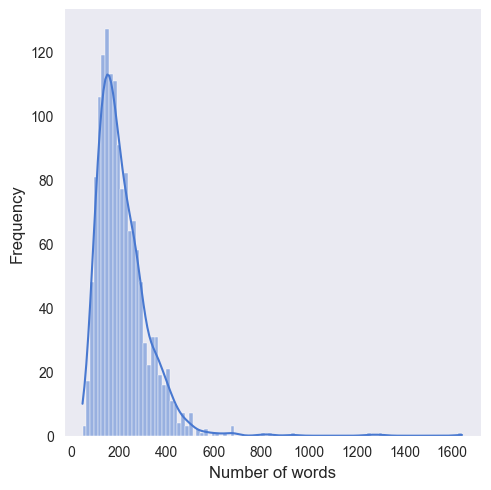

In [217]:
plt.figure(figsize=(14,6))      
sns.displot(df_train_news['num_words_pre'], kind='hist', kde= True, bins=100)   
plt.xlabel('Number of words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

We see a fairly skewed distribution, with most articles having between 100 and 300 words. It's a good idea to remove some outliers based in the number of words.

Text(0.5, 1.0, 'Number of words by category')

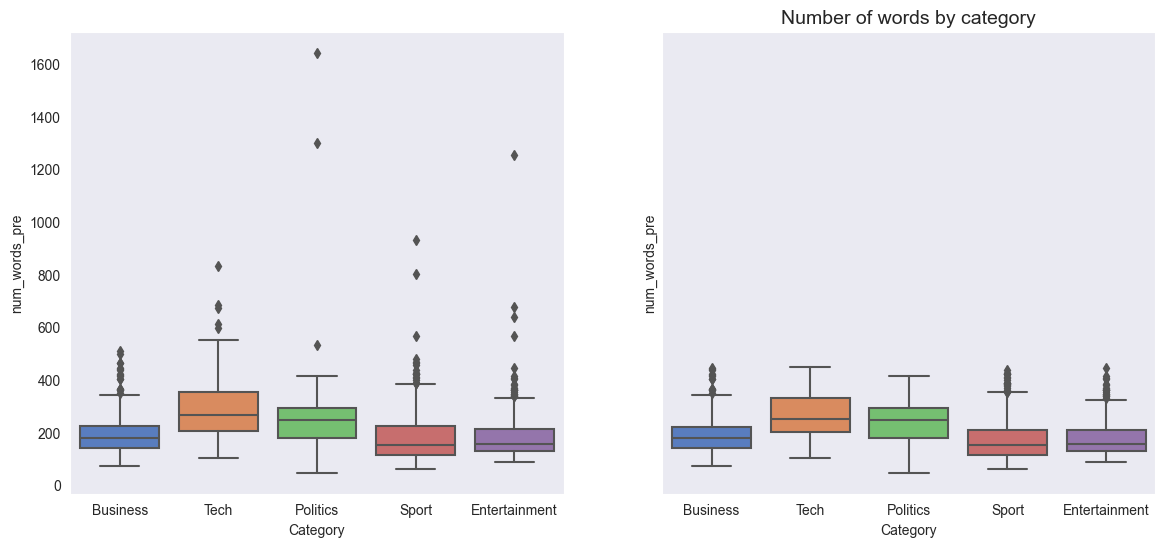

In [218]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), sharey=True)     
sns.boxplot(x='Category', y='num_words_pre', data=df_train_news, ax=ax[0])
plt.title('Number of words by category', fontsize=14)           
q1 = df_train_news['num_words_pre'].quantile(0.25)      
q3 = df_train_news['num_words_pre'].quantile(0.75)  
iqr = q3 - q1
upper_limit = q3 + 1.5*iqr  
lower_limit = q1 - 1.5*iqr
df_train_cleaned = df_train_news[(df_train_news['num_words_pre'] > lower_limit) & (df_train_news['num_words_pre'] < upper_limit)]
sns.boxplot(x='Category', y='num_words_pre', data=df_train_cleaned, ax=ax[1])
plt.title('Number of words by category', fontsize=14)    

The politics category has the highest average word count, followed by tech, business, entertainment and sport. However there are more articles in the tech category that have high word counts.               

Let's take a look at the most common words in each category.   

In [219]:
tmp = (df_train_cleaned.groupby('Category')['Text_preprocessed'].apply(lambda x: x.str.split(expand=True).stack().value_counts()).unstack().fillna(0).astype(int)).T
business = tmp['Business'].sort_values(ascending=False)[:10]    
entertainment = tmp['Entertainment'].sort_values(ascending=False)[:10]
politics = tmp['Politics'].sort_values(ascending=False)[:10]
sport = tmp['Sport'].sort_values(ascending=False)[:10]
tech = tmp['Tech'].sort_values(ascending=False)[:10]   
business

said       1087
year        603
bn          518
u           510
mr          393
company     391
firm        372
market      344
would       294
sale        277
Name: Business, dtype: int32

The word 'said' appears in almost all the categories as one of the most used in the articles, this word importance is going to be reduced using TF-IDF technique. The word 'mr' appears in the politics category, which makes sense. The word 'game' appears in the entertainment and sport categories, which also makes sense. The word 'company' appears in the business and tech categories, which also makes sense.

In [220]:
df_train_cleaned.drop(axis=1, columns=['num_words_no_pre', 'num_words_simple_pre', 'num_words_pre', 'Text'], inplace=True)

C:\Users\cozie\AppData\Local\Temp\ipykernel_13596\812482064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cleaned.drop(axis=1, columns=['num_words_no_pre', 'num_words_simple_pre', 'num_words_pre', 'Text'], inplace=True)


In [221]:
codes, uniques = pd.factorize(df_train_cleaned['Category'])
df_train_cleaned['Target'] = codes
df_train_cleaned    

C:\Users\cozie\AppData\Local\Temp\ipykernel_13596\4200020037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_cleaned['Target'] = codes


,Category,Text_preprocessed,Target
ArticleId,,,
1833,Business,worldcom ex bos launch defence lawyer defendin...,0
154,Business,german business confidence slide german busine...,0
1101,Business,bbc poll indicates economic gloom citizen majo...,0
1976,Tech,lifestyle governs mobile choice faster better ...,1
917,Business,enron boss payout eighteen former enron direct...,0
...,...,...,...
857,Entertainment,double eviction big brother model caprice holb...,4
325,Entertainment,dj double act revamp chart show dj duo jk joel...,4
1590,Business,weak dollar hit reuters revenue medium group r...,0


## Splitting the data               

It's not necessary to split the data into train and validation sets because we are going to use unsupervised learning, however one can make a split to get an idea of how well the model is going to perforrm before subitting it to Kaggle, also to make a better comparison with the supervised learning model.

In [222]:
df_train, df_val = train_test_split(df_train_cleaned, test_size=0.2, random_state=random_seed, stratify=df_train_cleaned['Target'])

### TF-IDF           

As mentioned before we are going to use TF-IDF to obtained the importance of each term in our dataset of articles, also this will allow the model to recieve a matrix of numbers instead of words.

The TF-IDF is a measure of how important a word is to a document in a collection of documents. The importance increases proportionally to the number of times a word appears in the document but is reduced by the number of times the word appears in other documents of the collection, this is to control for the fact that some words appear more frequently in general and are less informative in the context of a particular document.  

The TF-IDF is composed of two terms: the first computes the Term Frequency(TF) which is the number of times a word appears in the specific document, divided by the total number of words in that document.

$tf(t,d) = \frac{f_{t,d}}{\sum_{t\prime{}\in d}f_{t\prime{},d}}$

where $f_{t,d}$ is the number of times the term $t$ appears in the document $d$.

 The second term is the Inverse Document Frequency(IDF), which is computed as the logarithm of the number of the documents in the collection divided by the number of documents where the specific term appears.

$idf(t,D) = \log{\frac{N}{|\{d\in D:t\in d\}|}}$

where $N$ is the total number of documents in the collection $D$ and $|\{d\in D:t\in d\}|$ is the number of documents where the term $t$ appears.          

The TF-IDF is the product of these two terms:

$tfidf(t,d,D) = tf(t,d) \times idf(t,D)$

An example of the TF-IDF for a document in a collection of documents is shown below:    

In [223]:
exmpl = df_train[:5]
tfidf_vectorizer = TfidfVectorizer()              
tfidf_train = tfidf_vectorizer.fit_transform(exmpl['Text_preprocessed'])
pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())   

,account,accountant,accused,acting,actor,actress,administrator,adornment,adrian,advice,...,whatsonstage,whether,winner,without,wonky,worked,would,writing,wrong,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052863,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035403,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076617,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.076617,0.076617,0.000000,0.000000,0.000000,0.123629
2,0.000000,0.000000,0.000000,0.000000,0.195408,0.146556,0.000000,0.000000,0.000000,0.000000,...,0.048852,0.000000,0.048852,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.041339,0.041339,0.000000,0.000000,0.000000,0.000000,0.000000,0.041339,...,0.000000,0.082677,0.000000,0.082677,0.000000,0.000000,0.166109,0.041339,0.041339,0.066703
4,0.098379,0.049189,0.000000,0.000000,0.000000,0.000000,0.049189,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032943,0.000000,0.000000,0.000000


In [224]:
nmf = NMF(n_components=5, random_state=random_seed)
tfidf = TfidfVectorizer(sublinear_tf=True,
                            max_df=0.95,
                            min_df=round(len(df_train)*0.01),
                            stop_words="english")
tfidf.fit(df_train['Text_preprocessed'])
X_train = tfidf.transform(df_train['Text_preprocessed'])     
X_train_nmf = nmf.fit_transform(X_train)         

In [225]:
def label_permutation(y_true,y_pred):
    y_true_ = np.array(y_true).reshape(-1)
    uniq_labels = np.unique(y_true_)
    perm = permutations(range(len(uniq_labels)))
    best_perm, best_acc = None, 0
    for p in perm:
        perm_true_label_map = {label: int_label for label, int_label in zip(uniq_labels, p)}
        perm_true_labels = np.array([perm_true_label_map[label] for label in y_true_])
        acc = accuracy_score(perm_true_labels, y_pred)
        if acc > best_acc:
            best_perm = {num: label for num, label in zip(p, uniq_labels)}
            best_acc = acc
    return best_perm, best_acc



def predict(y_pred, best_permutation):
    y_pred_perm = [best_permutation[int_label] for int_label in y_pred]
    return y_pred_perm

y_train_pred_noperm = np.argmax(X_train_nmf, axis=1)
best_permutation, best_score= label_permutation(df_train['Target'], y_train_pred_noperm)
y_train_pred = predict(y_train_pred_noperm, best_permutation)
print (f'Best permutation: {best_permutation}')
print (f'Accuracy score: {best_score}') 

Best permutation: {0: 0, 4: 1, 2: 2, 1: 3, 3: 4}
Accuracy score: 0.9448398576512456


<Axes: >

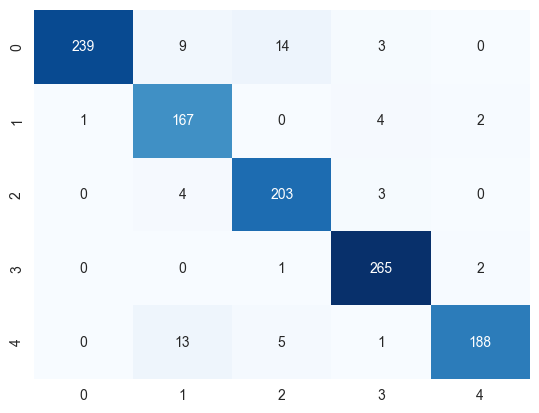

In [226]:
sns.heatmap(confusion_matrix(df_train['Target'], y_train_pred), annot=True, fmt='d', cmap='Blues', cbar=False)

Accuracy in validation set:  0.9395017793594306


<Axes: >

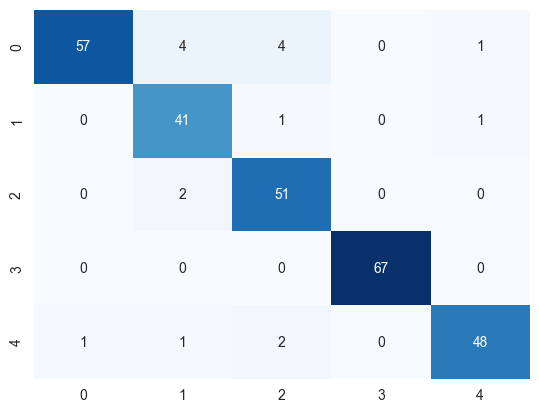

In [227]:
X_val = tfidf.transform(df_val['Text_preprocessed'])
X_val_nmf = nmf.transform(X_val)   
y_val_pred_noperm = np.argmax(X_val_nmf, axis=1) 
y_val_pred = predict(y_val_pred_noperm, best_permutation)   
print('Accuracy in validation set: ',accuracy_score(df_val['Target'], y_val_pred))
sns.heatmap(confusion_matrix(df_val['Target'], y_val_pred), annot=True, fmt='d', cmap='Blues', cbar=False)

In [228]:
df_test_news = pd.read_csv('data\BBC News Test.csv')
df_test_news['Text'] = df_test_news['Text'].apply(lambda x: re.sub("[^a-zA-Z]", ' ',x))
df_test_news['Text_preprocessed'] = df_test_news['Text'].apply(preprocess_article)
df_test_news.drop(axis=1, columns=['Text'], inplace=True)
df_test_news


,ArticleId,Text_preprocessed
0,1018,qpr keeper day head preston queen park ranger ...
1,1319,software watching work software monitor every ...
2,1138,arcy injury add ireland woe gordon arcy ruled ...
3,459,india reliance family feud heat ongoing public...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu probe alitalia state aid european commissio...
731,373,u play grammy award show irish rock band u pla...
732,1704,sport betting rule spotlight group mp peer cal...
733,206,alfa romeo get gm engine fiat stop making six ...


In [229]:
X_test = tfidf.transform(df_test_news['Text_preprocessed'])     
X_test_nmf = nmf.transform(X_test)  
y_test_pred_noperm = np.argmax(X_test_nmf, axis=1) 
y_test_pred = predict(y_test_pred_noperm, best_permutation) 
y_test_pred = pd.Series(y_test_pred, name='Category')
mapper = {i:label for i,label in enumerate(uniques.str.lower())}
test_preds = pd.DataFrame(columns=["ArticleId", "Category"])
test_preds["ArticleId"] = df_test_news.ArticleId
test_preds["Category"] = y_test_pred.map(mapper)
test_preds.to_csv('data\submission.csv', index=False)

In [230]:
!kaggle competitions submit -c learn-ai-bbc -f data\submission.csv -m Submission

Successfully submitted to BBC News Classification



  0%|          | 0.00/9.86k [00:00<?, ?B/s]
100%|██████████| 9.86k/9.86k [00:00<00:00, 96.3kB/s]
100%|██████████| 9.86k/9.86k [00:00<00:00, 23.9kB/s]
